In [1]:
import json
import os
import sys
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage
import tifffile
import yaml

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [5]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

In [6]:
run_dir = '/data/estorrs/mushroom/data/projects/submission_v1'

In [7]:
def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

## define inputs

###### HT413C1-Th1k4A1

In [8]:
case = 'HT413C1-Th1k4A1'
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))
metadata

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s0_HT413C1-Th1k4A1-U14_he.tif'}],
   'position': 0,
   'sid': 'HT413C1-Th1k4A1-U14'},
  {'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s1_HT413C1-Th1k4A1-U18_he.tif'}],
   'position': 20,
   'sid': 'HT413C1-Th1k4A1-U18'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s2_HT413C1-Th1k4A1-U19_xenium.h5ad'}],
   'position': 25,
   'sid': 'HT413C1-Th1k4A1-U19'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s3_HT413C1-Th1k4A1-U20_multiplex.ome.tiff'}],
   'position': 30,
   'sid': 'HT413C1-Th1k4A1-U20'},
  {'data': [{'dtype': 'he

In [9]:
exclude = ['HT413C1-Th1k4A1-U31'] # one of the xenium slides has detachment issues
metadata['sections'] = [x for x in metadata['sections'] if x['sid'] not in exclude]
metadata

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s0_HT413C1-Th1k4A1-U14_he.tif'}],
   'position': 0,
   'sid': 'HT413C1-Th1k4A1-U14'},
  {'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s1_HT413C1-Th1k4A1-U18_he.tif'}],
   'position': 20,
   'sid': 'HT413C1-Th1k4A1-U18'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s2_HT413C1-Th1k4A1-U19_xenium.h5ad'}],
   'position': 25,
   'sid': 'HT413C1-Th1k4A1-U19'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s3_HT413C1-Th1k4A1-U20_multiplex.ome.tiff'}],
   'position': 30,
   'sid': 'HT413C1-Th1k4A1-U20'},
  {'data': [{'dtype': 'he

## train mushroom

In [10]:
DEFAULT_CONFIG

{'sections': None,
 'dtype_to_chkpt': None,
 'dtype_specific_params': {'visium': {'trainer_kwargs': {'tiling_method': 'radius'}}},
 'sae_kwargs': {'size': 8,
  'patch_size': 1,
  'encoder_dim': 128,
  'codebook_dim': 64,
  'num_clusters': (8, 4, 2),
  'dtype_to_decoder_dims': {'multiplex': (256, 128, 64),
   'he': (256, 128, 10),
   'visium': (256, 512, 2048),
   'xenium': (256, 256, 256),
   'cosmx': (256, 512, 1024),
   'points': (256, 512, 1024)},
  'recon_scaler': 1.0,
  'neigh_scaler': 0.01},
 'trainer_kwargs': {'input_resolution': 1.0,
  'target_resolution': 0.02,
  'pct_expression': 0.05,
  'log_base': 2.718281828459045,
  'tiling_method': 'grid',
  'tiling_radius': 1.0,
  'batch_size': 128,
  'num_workers': 0,
  'devices': 1,
  'accelerator': 'cpu',
  'max_epochs': 1,
  'steps_per_epoch': 1000,
  'lr': 0.0001,
  'out_dir': './outputs',
  'save_every': 1,
  'log_every_n_steps': 10,
  'logger_type': 'tensorboard',
  'logger_project': 'portobello',
  'channel_mapping': {},
  'data

In [11]:
config = deepcopy(DEFAULT_CONFIG)

mask_fp = os.path.join(run_dir, case, 'masks', 'tissue_mask.tif')
if not os.path.exists(mask_fp):
    mask_fp = None
mask_fp = None

config = utils.recursive_update(config, {
    'sections': metadata['sections'],
    'trainer_kwargs': {
        'input_resolution': metadata['resolution'],
        'target_resolution': .02,
        'out_dir': os.path.join(run_dir, case, 'mushroom'),
        'accelerator': 'gpu',
        'steps_per_epoch': 1000,
        'data_mask': mask_fp,
    }
})

config['dtype_specific_params'] = utils.recursive_update(config['dtype_specific_params'], {
    'visium': {
        'trainer_kwargs': {
            'target_resolution': .01  # lower resolution for visium
        }
    }
})

config = alter_filesystem(config, source_root, target_root)
config

{'sections': [{'data': [{'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s0_HT413C1-Th1k4A1-U14_he.tif'}],
   'position': 0,
   'sid': 'HT413C1-Th1k4A1-U14'},
  {'data': [{'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s1_HT413C1-Th1k4A1-U18_he.tif'}],
   'position': 20,
   'sid': 'HT413C1-Th1k4A1-U18'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s2_HT413C1-Th1k4A1-U19_xenium.h5ad'}],
   'position': 25,
   'sid': 'HT413C1-Th1k4A1-U19'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s3_HT413C1-Th1k4A1-U20_multiplex.ome.tiff'}],
   'position': 30,
   'sid': 'HT413C1-Th1k4A1-U20'},
  {'data': [{'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/regi

In [12]:
mushroom = Mushroom.from_config(config)

INFO:root:loading spore for cosmx
INFO:root:data mask detected
INFO:root:starting cosmx processing
INFO:root:using 1000 channels
INFO:root:2 sections detected: ['HT413C1-Th1k4A1-U7', 'HT413C1-Th1k4A1-U34']
INFO:root:processing sections
INFO:root:generating image data for section HT413C1-Th1k4A1-U7
INFO:root:generating image data for section HT413C1-Th1k4A1-U34
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT413C1-Th1k4A1-U7', 'cosmx'), ('HT413C1-Th1k4A1-U34', 'cosmx')]
INFO:root:creating data loaders
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmp1ae2ouae
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmp1ae2ouae/_remote_module_non_scriptable.py
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore

In [13]:
mushroom.train()

INFO:root:starting training for cosmx
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom/cosmx_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 6.7 M 
------------------------------
6.7 M     Trainable params
0         Non-trainable params
6.7 M     Total params
26.969    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training cosmx, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom/cosmx_chkpts/last-v2.ckpt
INFO:root:starting training for he
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom/he_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.874    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training he, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom/he_chkpts/last-v2.ckpt
INFO:root:starting training for multiplex
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom/multiplex_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.918    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training multiplex, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom/multiplex_chkpts/last-v2.ckpt
INFO:root:starting training for xenium
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom/xenium_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.2 M 
------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.992    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training xenium, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom/xenium_chkpts/last-v2.ckpt


In [14]:
mushroom.embed_sections()

INFO:root:embedding cosmx spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

cosmx 0


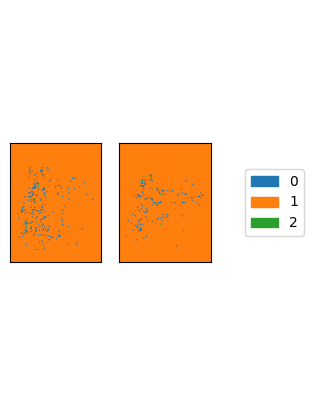

cosmx 1


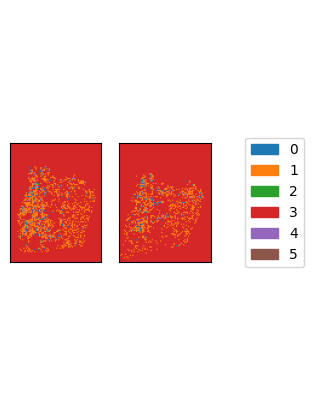

cosmx 2


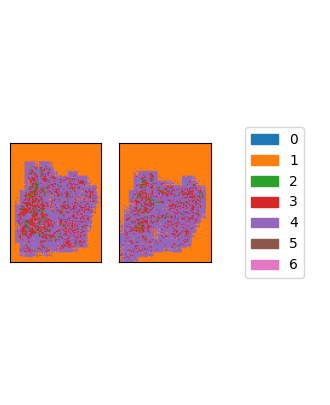

he 0


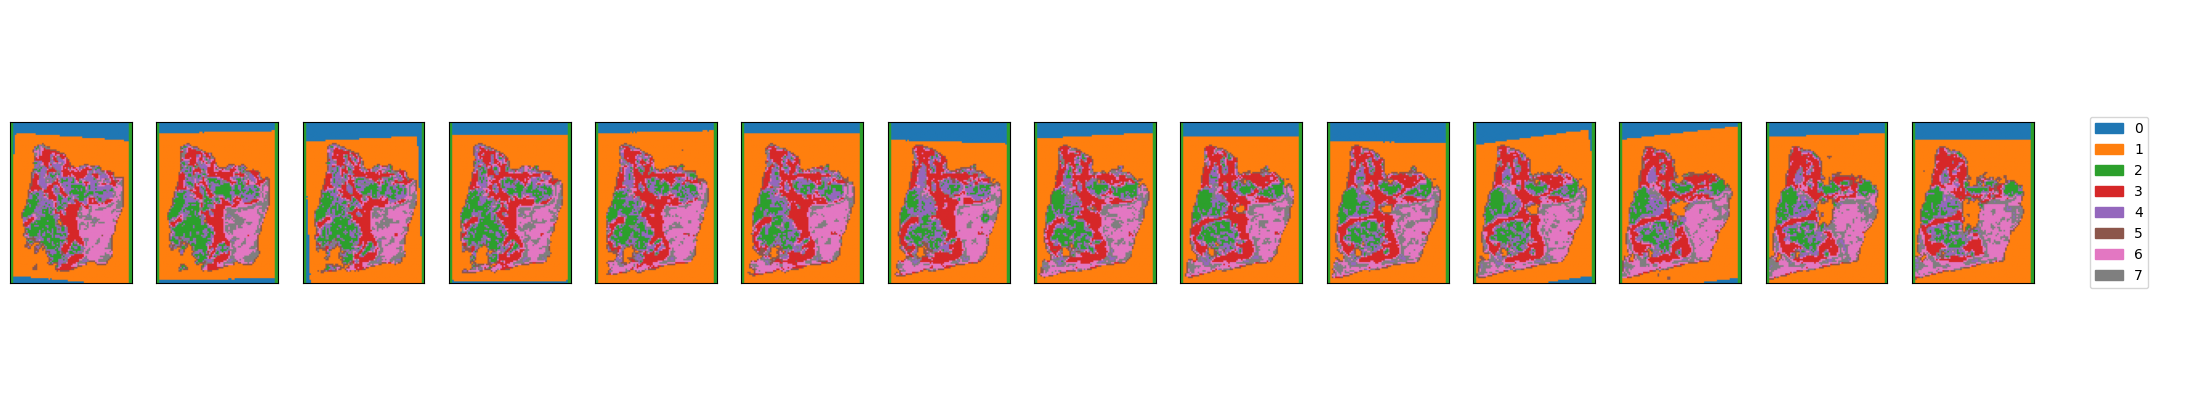

he 1


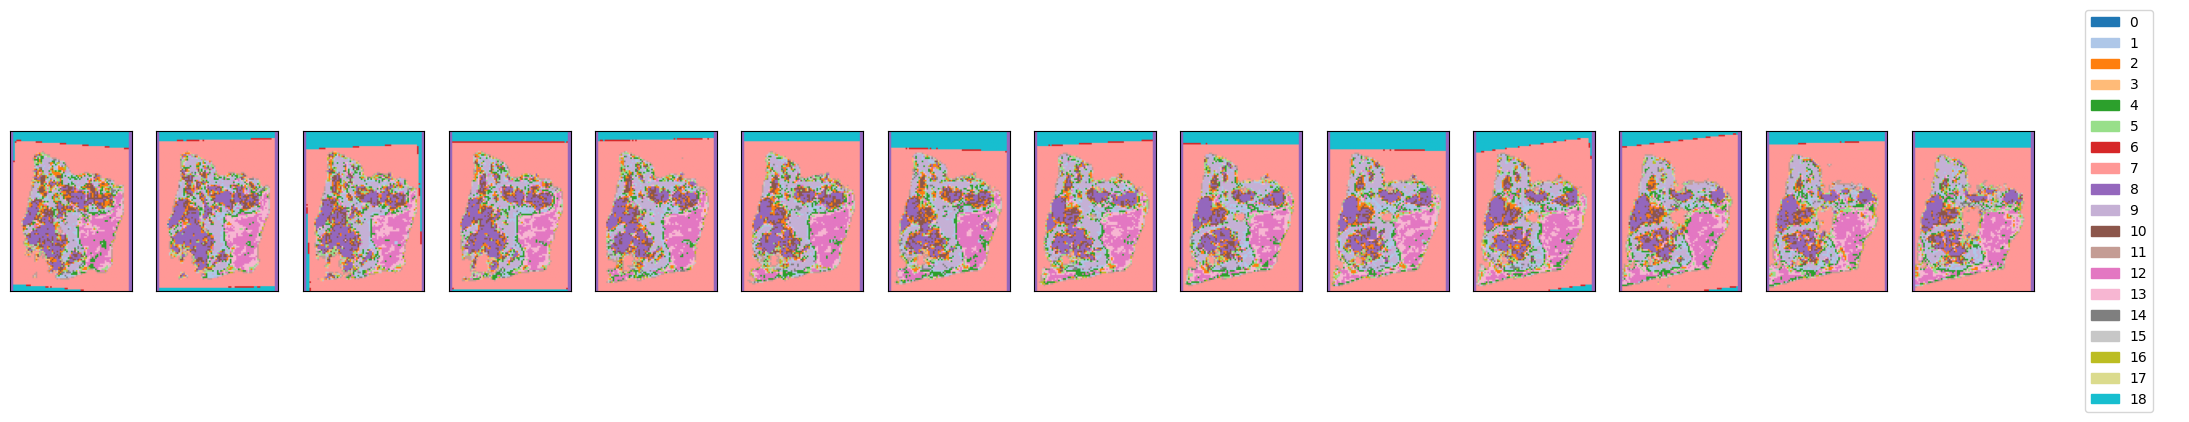

he 2


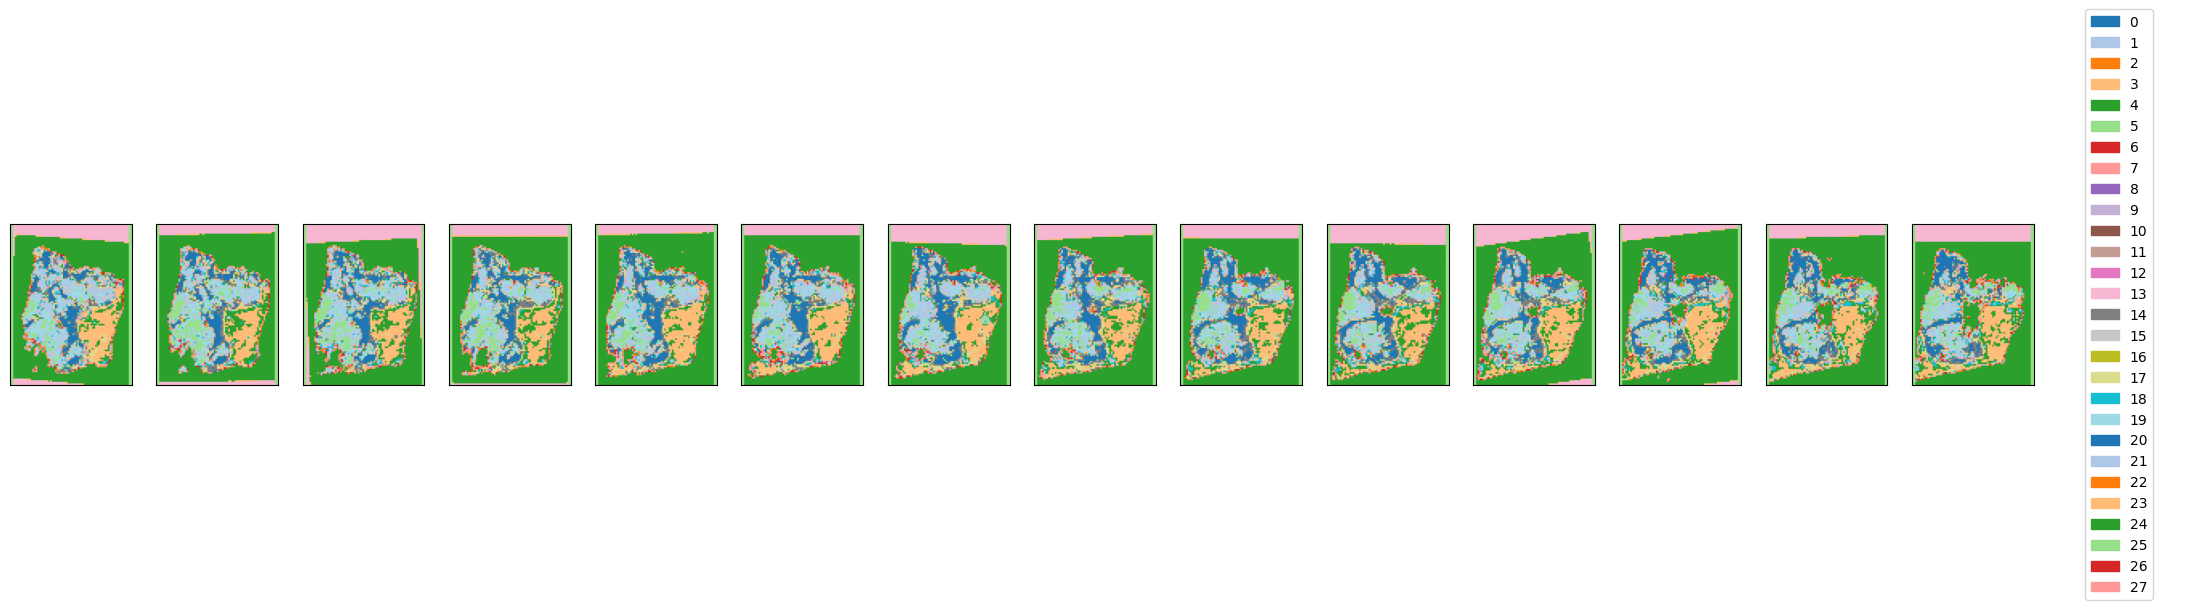

multiplex 0


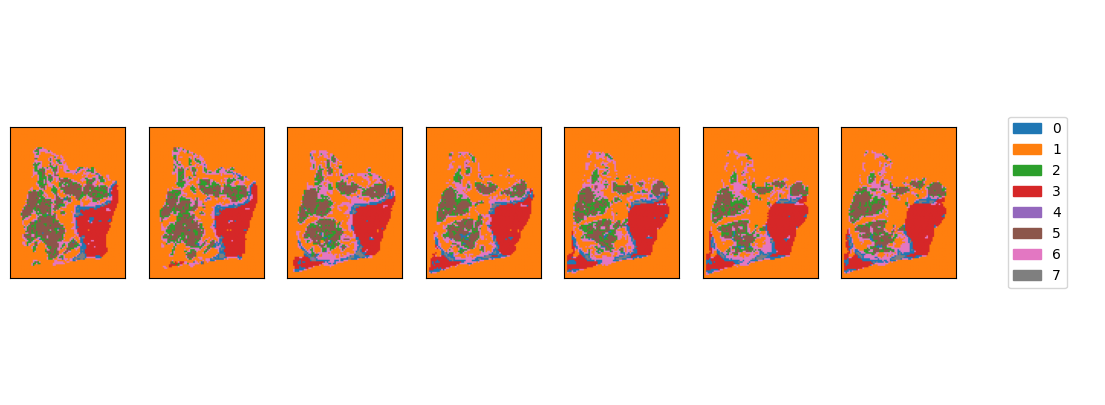

multiplex 1


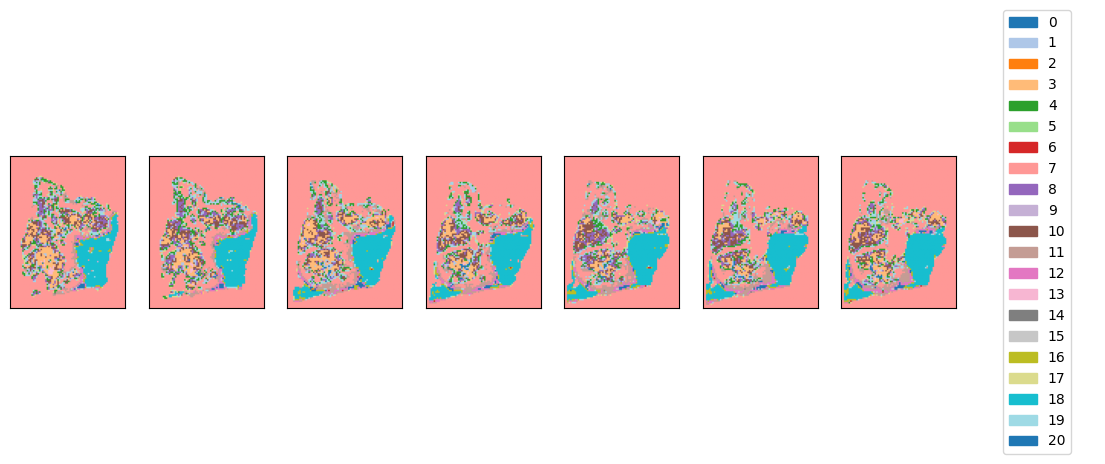

multiplex 2


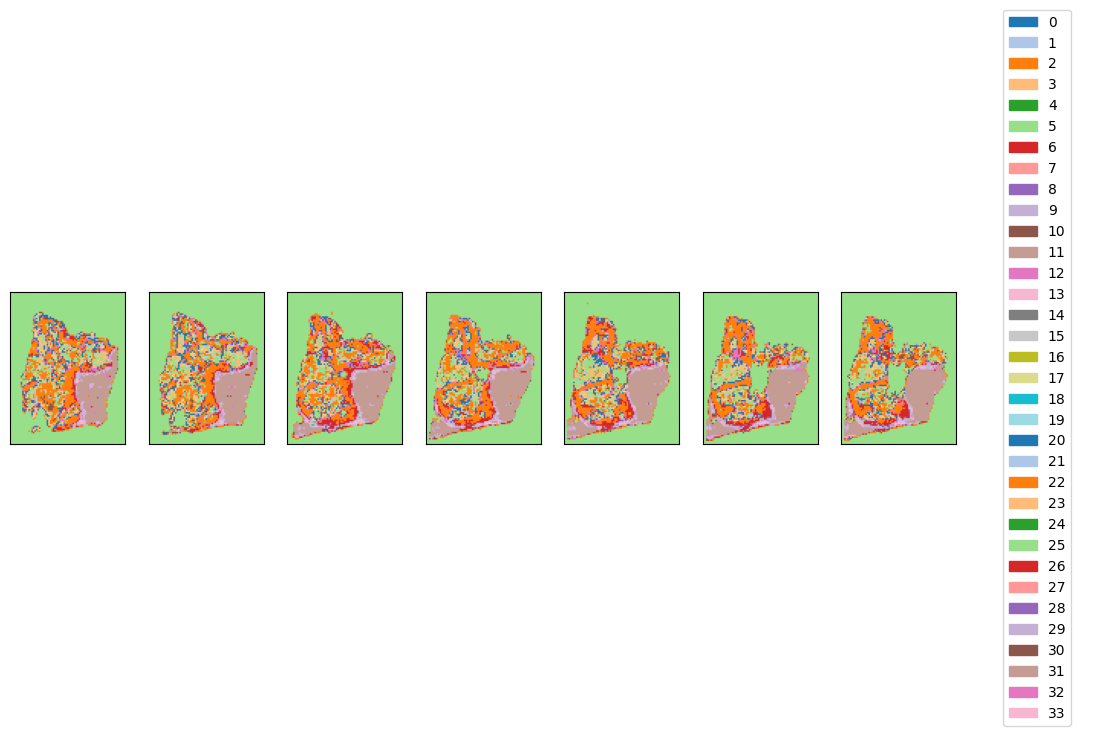

xenium 0


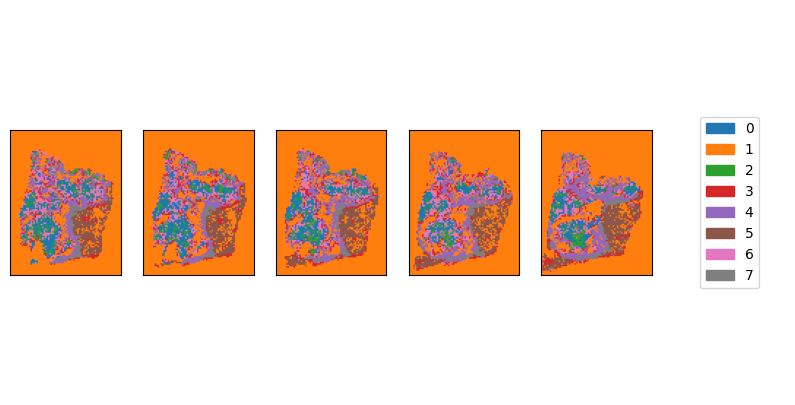

xenium 1


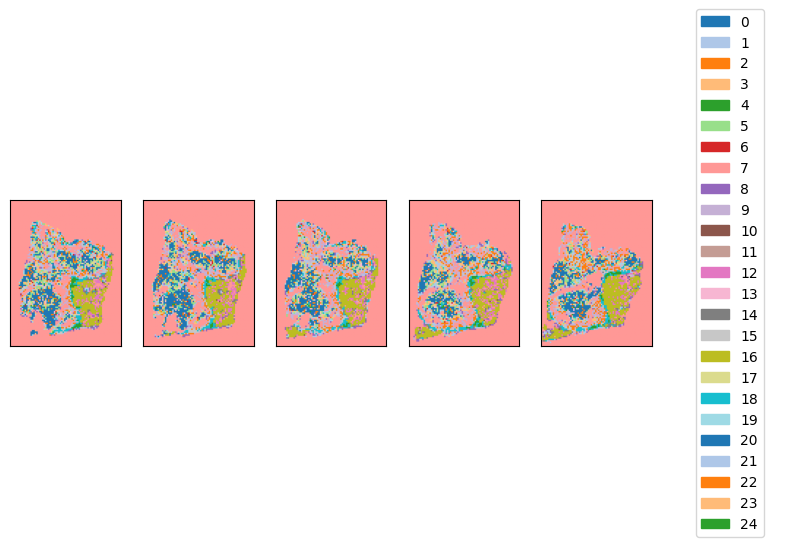

xenium 2


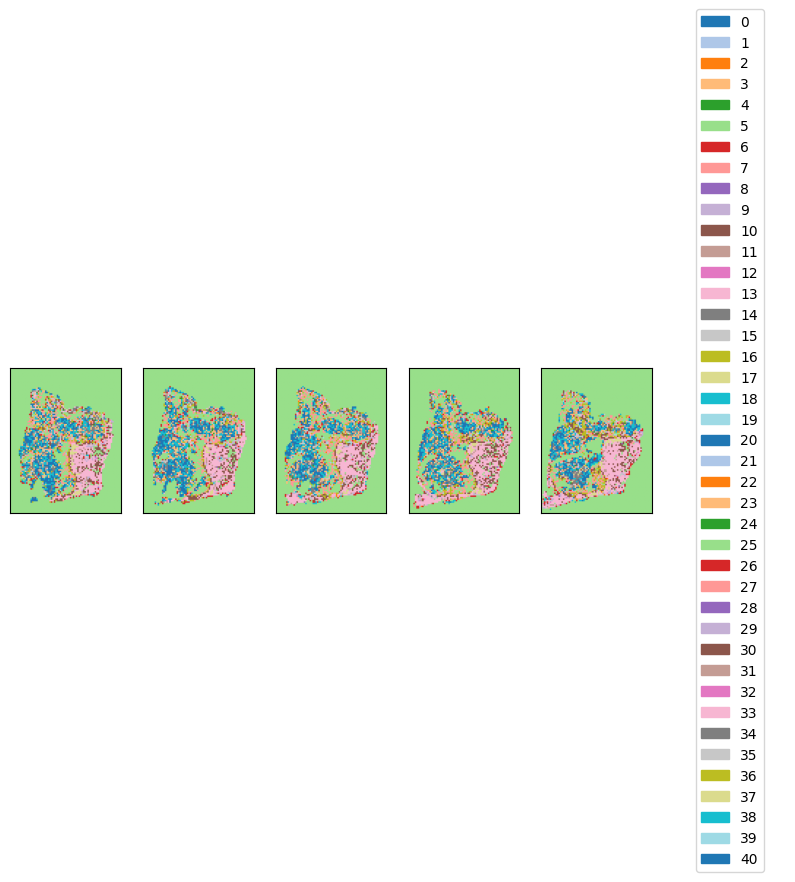

In [15]:
for dtype in mushroom.dtypes:
    for level in range(mushroom.num_levels):
        print(dtype, level)
        mushroom.display_clusters(dtype, level=level)
        plt.show()

INFO:root:generating volume for cosmx spore
INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 300304 edges
INFO:root:10194 edges remaining after filtering
INFO:root:548 of 548 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 6 clusters


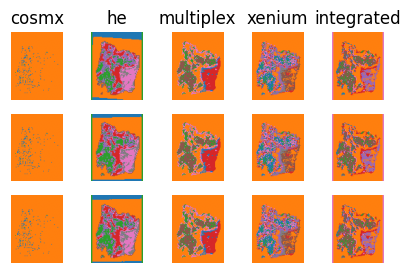

In [16]:
z_scaler = .2
level = 0
resolution = 1.
dtype_to_weight = {
    'he': 1.,
    'multiplex': 1.,
    'xenium': 1.,
    'cosmx': 0.
}

dtype_to_volume_l0 = mushroom.generate_interpolated_volumes(
    z_scaler=.2, level=0, integrate=True, dtype_to_weight=dtype_to_weight, resolution=resolution)

dtype_to_volume_l0_labels = {k:v.argmax(-1) if k != 'integrated' else v for k, v in dtype_to_volume_l0.items()}

mushroom.display_volumes(dtype_to_volume=dtype_to_volume_l0_labels, positions=[1,2,3])


INFO:root:generating volume for cosmx spore
INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 25887744 edges
INFO:root:484262 edges remaining after filtering
INFO:root:5088 of 5088 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 13 clusters


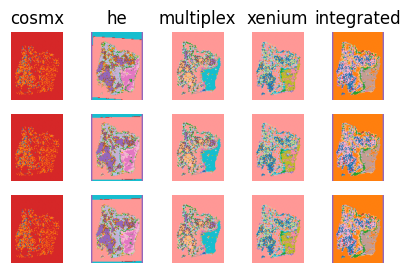

In [17]:
z_scaler = .2
level = 1
resolution = 1.5
dtype_to_weight = {
    'he': 1.,
    'multiplex': 1.,
    'xenium': 1.,
    'cosmx': 0.
}

dtype_to_volume_l1 = mushroom.generate_interpolated_volumes(
    z_scaler=.2, level=1, integrate=True, dtype_to_weight=dtype_to_weight, resolution=resolution)

dtype_to_volume_l1_labels = {k:v.argmax(-1) if k != 'integrated' else v for k, v in dtype_to_volume_l1.items()}

mushroom.display_volumes(dtype_to_volume=dtype_to_volume_l1_labels, positions=[1,2,3])


INFO:root:generating volume for cosmx spore
INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 77070841 edges
INFO:root:1270049 edges remaining after filtering
INFO:root:8779 of 8779 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 16 clusters


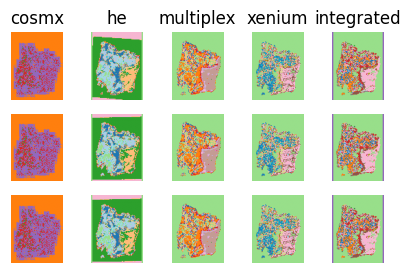

In [18]:
z_scaler = .2
level = 2
resolution = 2.
dtype_to_weight = {
    'he': 1.,
    'multiplex': 1.,
    'xenium': 1.,
    'cosmx': 0.
}

dtype_to_volume_l2 = mushroom.generate_interpolated_volumes(
    z_scaler=.2, level=2, integrate=True, dtype_to_weight=dtype_to_weight, resolution=resolution)

dtype_to_volume_l2_labels = {k:v.argmax(-1) if k != 'integrated' else v for k, v in dtype_to_volume_l2.items()}

mushroom.display_volumes(dtype_to_volume=dtype_to_volume_l2_labels, positions=[1,2,3])


In [101]:
%%time
for case, config in case_to_config.items():
    print(case)
    mushroom = Mushroom.from_config(config)
    mushroom.train()
    mushroom.embed_sections()
    
    mushroom.save()
    z_scaler = 1.
    for level in range(3):
        dtype_to_volume = mushroom.generate_interpolated_volumes(z_scaler=z_scaler, level=level, integrate=False)
        volume = dtype_to_volume['multiplex']
        np.save(os.path.join(mushroom.trainer_kwargs['out_dir'], f'volume_l{level}.npy'), volume)
    
    del(mushroom)
    

INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing


HT427PI-A1_20x_keepevery1


INFO:root:using 4 channels
INFO:root:100 sections detected: ['HT427PI-A1-U289', 'HT427PI-A1-U290', 'HT427PI-A1-U291', 'HT427PI-A1-U292', 'HT427PI-A1-U293', 'HT427PI-A1-U294', 'HT427PI-A1-U295', 'HT427PI-A1-U296', 'HT427PI-A1-U297', 'HT427PI-A1-U298', 'HT427PI-A1-U299', 'HT427PI-A1-U300', 'HT427PI-A1-U301', 'HT427PI-A1-U302', 'HT427PI-A1-U303', 'HT427PI-A1-U304', 'HT427PI-A1-U305', 'HT427PI-A1-U306', 'HT427PI-A1-U307', 'HT427PI-A1-U308', 'HT427PI-A1-U309', 'HT427PI-A1-U310', 'HT427PI-A1-U311', 'HT427PI-A1-U312', 'HT427PI-A1-U313', 'HT427PI-A1-U314', 'HT427PI-A1-U315', 'HT427PI-A1-U316', 'HT427PI-A1-U317', 'HT427PI-A1-U318', 'HT427PI-A1-U319', 'HT427PI-A1-U320', 'HT427PI-A1-U321', 'HT427PI-A1-U322', 'HT427PI-A1-U323', 'HT427PI-A1-U324', 'HT427PI-A1-U325', 'HT427PI-A1-U326', 'HT427PI-A1-U327', 'HT427PI-A1-U328', 'HT427PI-A1-U329', 'HT427PI-A1-U330', 'HT427PI-A1-U331', 'HT427PI-A1-U332', 'HT427PI-A1-U333', 'HT427PI-A1-U334', 'HT427PI-A1-U335', 'HT427PI-A1-U336', 'HT427PI-A1-U337', 'HT427PI

INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:starting training for multiplex
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A1_20x/mushroom/HT427PI-A1_20x_keepevery1/multiplex_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.948    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'tra

Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training multiplex, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A1_20x/mushroom/HT427PI-A1_20x_keepevery1/multiplex_chkpts/last-v4.ckpt
INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:saving config and outputs to /data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A1_20x/mushroom/HT427PI-A1_20x_keepevery1
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for multiplex spore
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing


HT427PI-A2_20x_keepevery1


INFO:root:using 4 channels
INFO:root:100 sections detected: ['HT427PI-A2-U368', 'HT427PI-A2-U369', 'HT427PI-A2-U370', 'HT427PI-A2-U371', 'HT427PI-A2-U372', 'HT427PI-A2-U373', 'HT427PI-A2-U374', 'HT427PI-A2-U375', 'HT427PI-A2-U376', 'HT427PI-A2-U377', 'HT427PI-A2-U378', 'HT427PI-A2-U379', 'HT427PI-A2-U380', 'HT427PI-A2-U381', 'HT427PI-A2-U382', 'HT427PI-A2-U383', 'HT427PI-A2-U384', 'HT427PI-A2-U385', 'HT427PI-A2-U386', 'HT427PI-A2-U387', 'HT427PI-A2-U388', 'HT427PI-A2-U389', 'HT427PI-A2-U390', 'HT427PI-A2-U391', 'HT427PI-A2-U392', 'HT427PI-A2-U393', 'HT427PI-A2-U394', 'HT427PI-A2-U395', 'HT427PI-A2-U396', 'HT427PI-A2-U397', 'HT427PI-A2-U398', 'HT427PI-A2-U399', 'HT427PI-A2-U400', 'HT427PI-A2-U401', 'HT427PI-A2-U402', 'HT427PI-A2-U403', 'HT427PI-A2-U404', 'HT427PI-A2-U405', 'HT427PI-A2-U406', 'HT427PI-A2-U407', 'HT427PI-A2-U408', 'HT427PI-A2-U409', 'HT427PI-A2-U410', 'HT427PI-A2-U411', 'HT427PI-A2-U412', 'HT427PI-A2-U413', 'HT427PI-A2-U414', 'HT427PI-A2-U415', 'HT427PI-A2-U416', 'HT427PI

INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:starting training for multiplex
Missing logger folder: /data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A2_20x/mushroom/HT427PI-A2_20x_keepevery1/multiplex_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.948    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` t

Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training multiplex, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A2_20x/mushroom/HT427PI-A2_20x_keepevery1/multiplex_chkpts/last.ckpt
INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:saving config and outputs to /data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A2_20x/mushroom/HT427PI-A2_20x_keepevery1
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for multiplex spore
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing


HT427PI-A3_20x_keepevery1


INFO:root:using 4 channels
INFO:root:100 sections detected: ['HT427PI-A3-U393', 'HT427PI-A3-U394', 'HT427PI-A3-U395', 'HT427PI-A3-U396', 'HT427PI-A3-U397', 'HT427PI-A3-U398', 'HT427PI-A3-U399', 'HT427PI-A3-U400', 'HT427PI-A3-U401', 'HT427PI-A3-U402', 'HT427PI-A3-U403', 'HT427PI-A3-U404', 'HT427PI-A3-U405', 'HT427PI-A3-U406', 'HT427PI-A3-U407', 'HT427PI-A3-U408', 'HT427PI-A3-U409', 'HT427PI-A3-U410', 'HT427PI-A3-U411', 'HT427PI-A3-U412', 'HT427PI-A3-U413', 'HT427PI-A3-U414', 'HT427PI-A3-U415', 'HT427PI-A3-U416', 'HT427PI-A3-U417', 'HT427PI-A3-U418', 'HT427PI-A3-U419', 'HT427PI-A3-U420', 'HT427PI-A3-U421', 'HT427PI-A3-U422', 'HT427PI-A3-U423', 'HT427PI-A3-U424', 'HT427PI-A3-U425', 'HT427PI-A3-U426', 'HT427PI-A3-U427', 'HT427PI-A3-U428', 'HT427PI-A3-U429', 'HT427PI-A3-U430', 'HT427PI-A3-U431', 'HT427PI-A3-U432', 'HT427PI-A3-U433', 'HT427PI-A3-U434', 'HT427PI-A3-U435', 'HT427PI-A3-U436', 'HT427PI-A3-U437', 'HT427PI-A3-U438', 'HT427PI-A3-U439', 'HT427PI-A3-U440', 'HT427PI-A3-U441', 'HT427PI

INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:starting training for multiplex
Missing logger folder: /data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A3_20x/mushroom/HT427PI-A3_20x_keepevery1/multiplex_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.948    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` t

Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training multiplex, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A3_20x/mushroom/HT427PI-A3_20x_keepevery1/multiplex_chkpts/last.ckpt
INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:saving config and outputs to /data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A3_20x/mushroom/HT427PI-A3_20x_keepevery1
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for multiplex spore
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing


HT427PI-A4_20x_keepevery1


INFO:root:using 4 channels
INFO:root:100 sections detected: ['HT427PI-A4-U387', 'HT427PI-A4-U388', 'HT427PI-A4-U389', 'HT427PI-A4-U390', 'HT427PI-A4-U391', 'HT427PI-A4-U392', 'HT427PI-A4-U393', 'HT427PI-A4-U394', 'HT427PI-A4-U395', 'HT427PI-A4-U396', 'HT427PI-A4-U397', 'HT427PI-A4-U398', 'HT427PI-A4-U399', 'HT427PI-A4-U400', 'HT427PI-A4-U401', 'HT427PI-A4-U402', 'HT427PI-A4-U403', 'HT427PI-A4-U404', 'HT427PI-A4-U405', 'HT427PI-A4-U406', 'HT427PI-A4-U407', 'HT427PI-A4-U408', 'HT427PI-A4-U409', 'HT427PI-A4-U410', 'HT427PI-A4-U411', 'HT427PI-A4-U412', 'HT427PI-A4-U413', 'HT427PI-A4-U414', 'HT427PI-A4-U415', 'HT427PI-A4-U416', 'HT427PI-A4-U417', 'HT427PI-A4-U418', 'HT427PI-A4-U419', 'HT427PI-A4-U420', 'HT427PI-A4-U421', 'HT427PI-A4-U422', 'HT427PI-A4-U423', 'HT427PI-A4-U424', 'HT427PI-A4-U425', 'HT427PI-A4-U426', 'HT427PI-A4-U427', 'HT427PI-A4-U428', 'HT427PI-A4-U429', 'HT427PI-A4-U430', 'HT427PI-A4-U431', 'HT427PI-A4-U432', 'HT427PI-A4-U433', 'HT427PI-A4-U434', 'HT427PI-A4-U435', 'HT427PI

INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:starting training for multiplex
Missing logger folder: /data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A4_20x/mushroom/HT427PI-A4_20x_keepevery1/multiplex_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.948    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` t

Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training multiplex, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A4_20x/mushroom/HT427PI-A4_20x_keepevery1/multiplex_chkpts/last.ckpt
INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:saving config and outputs to /data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A4_20x/mushroom/HT427PI-A4_20x_keepevery1
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for multiplex spore
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing


HT442PI-A1_20x_keepevery1


INFO:root:using 4 channels
INFO:root:100 sections detected: ['HT442PI-A1-U317', 'HT442PI-A1-U318', 'HT442PI-A1-U319', 'HT442PI-A1-U320', 'HT442PI-A1-U321', 'HT442PI-A1-U322', 'HT442PI-A1-U323', 'HT442PI-A1-U324', 'HT442PI-A1-U325', 'HT442PI-A1-U326', 'HT442PI-A1-U327', 'HT442PI-A1-U328', 'HT442PI-A1-U329', 'HT442PI-A1-U330', 'HT442PI-A1-U331', 'HT442PI-A1-U332', 'HT442PI-A1-U333', 'HT442PI-A1-U334', 'HT442PI-A1-U335', 'HT442PI-A1-U336', 'HT442PI-A1-U337', 'HT442PI-A1-U338', 'HT442PI-A1-U339', 'HT442PI-A1-U340', 'HT442PI-A1-U341', 'HT442PI-A1-U342', 'HT442PI-A1-U343', 'HT442PI-A1-U344', 'HT442PI-A1-U345', 'HT442PI-A1-U346', 'HT442PI-A1-U347', 'HT442PI-A1-U348', 'HT442PI-A1-U349', 'HT442PI-A1-U350', 'HT442PI-A1-U351', 'HT442PI-A1-U352', 'HT442PI-A1-U353', 'HT442PI-A1-U354', 'HT442PI-A1-U355', 'HT442PI-A1-U356', 'HT442PI-A1-U357', 'HT442PI-A1-U358', 'HT442PI-A1-U359', 'HT442PI-A1-U360', 'HT442PI-A1-U361', 'HT442PI-A1-U362', 'HT442PI-A1-U363', 'HT442PI-A1-U364', 'HT442PI-A1-U365', 'HT442PI

INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:starting training for multiplex
Missing logger folder: /data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT442PI-A1_20x/mushroom/HT442PI-A1_20x_keepevery1/multiplex_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.948    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` t

Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training multiplex, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT442PI-A1_20x/mushroom/HT442PI-A1_20x_keepevery1/multiplex_chkpts/last.ckpt
INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:saving config and outputs to /data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT442PI-A1_20x/mushroom/HT442PI-A1_20x_keepevery1
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for multiplex spore
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing


HT442PI-A2_20x_keepevery1


INFO:root:using 4 channels
INFO:root:100 sections detected: ['HT442PI-A2-U275', 'HT442PI-A2-U276', 'HT442PI-A2-U277', 'HT442PI-A2-U278', 'HT442PI-A2-U279', 'HT442PI-A2-U280', 'HT442PI-A2-U281', 'HT442PI-A2-U282', 'HT442PI-A2-U283', 'HT442PI-A2-U284', 'HT442PI-A2-U285', 'HT442PI-A2-U286', 'HT442PI-A2-U287', 'HT442PI-A2-U288', 'HT442PI-A2-U289', 'HT442PI-A2-U290', 'HT442PI-A2-U291', 'HT442PI-A2-U292', 'HT442PI-A2-U293', 'HT442PI-A2-U294', 'HT442PI-A2-U295', 'HT442PI-A2-U296', 'HT442PI-A2-U297', 'HT442PI-A2-U298', 'HT442PI-A2-U299', 'HT442PI-A2-U300', 'HT442PI-A2-U301', 'HT442PI-A2-U302', 'HT442PI-A2-U303', 'HT442PI-A2-U304', 'HT442PI-A2-U305', 'HT442PI-A2-U306', 'HT442PI-A2-U307', 'HT442PI-A2-U308', 'HT442PI-A2-U309', 'HT442PI-A2-U310', 'HT442PI-A2-U311', 'HT442PI-A2-U312', 'HT442PI-A2-U313', 'HT442PI-A2-U314', 'HT442PI-A2-U315', 'HT442PI-A2-U316', 'HT442PI-A2-U317', 'HT442PI-A2-U318', 'HT442PI-A2-U319', 'HT442PI-A2-U320', 'HT442PI-A2-U321', 'HT442PI-A2-U322', 'HT442PI-A2-U323', 'HT442PI

INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:starting training for multiplex
Missing logger folder: /data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT442PI-A2_20x/mushroom/HT442PI-A2_20x_keepevery1/multiplex_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.948    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` t

Training: |                                                                                                   …

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


ValueError: zero-size array to reduction operation maximum which has no identity